In [1]:
from glob import glob
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from astropy.io import fits
from expres.config import get_ccf_mask
from expres.rv.ccf import order_wise_ccfs, generate_ccf_mask, coadd_ccfs
from expres.config import BLUE_ORDER, RED_ORDER
from tqdm.auto import tqdm

In [2]:
fmt = "phoenix/lte0{teff}-{logg:.2f}-{feh:.1f}.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits"
λ = fits.getdata("phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")

In [3]:
data = fits.getdata("expres/62044_190225.1111.fits", 1)
mask = "K2"
logg = 2.50
feh = 0.

In [3]:
data = fits.getdata("expres/101501_200228.1094.fits", 1)
mask = "G8"
logg = 4.50
feh = 0.

In [4]:
λ_expres = data['bary_wavelength']
mask_expres = np.isnan(data['spectrum'])
norm_expres = np.nansum(data['spectrum'])
ccf_mask = f"ESPRESSO_{mask}.fits"

N_color_corr = 15
y_color_corr = np.nansum(data['spectrum'], axis=1)
λ_color_corr = np.nanmean(λ_expres, axis=1)
p_color_corr = np.polyfit(λ_color_corr, np.log(y_color_corr), N_color_corr)

/home/joel/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
vspacing, masks = generate_ccf_mask(ccf_mask, λ_expres)
vrange = 5e6 # 20 km/s
v_grid = np.arange(-vrange, vrange, vspacing)

<ipython-input-6-6d709d26dc10>:1: RuntimeWarning: invalid value encountered in sqrt
  q = data['uncertainty'] / np.sqrt(data['spectrum'])


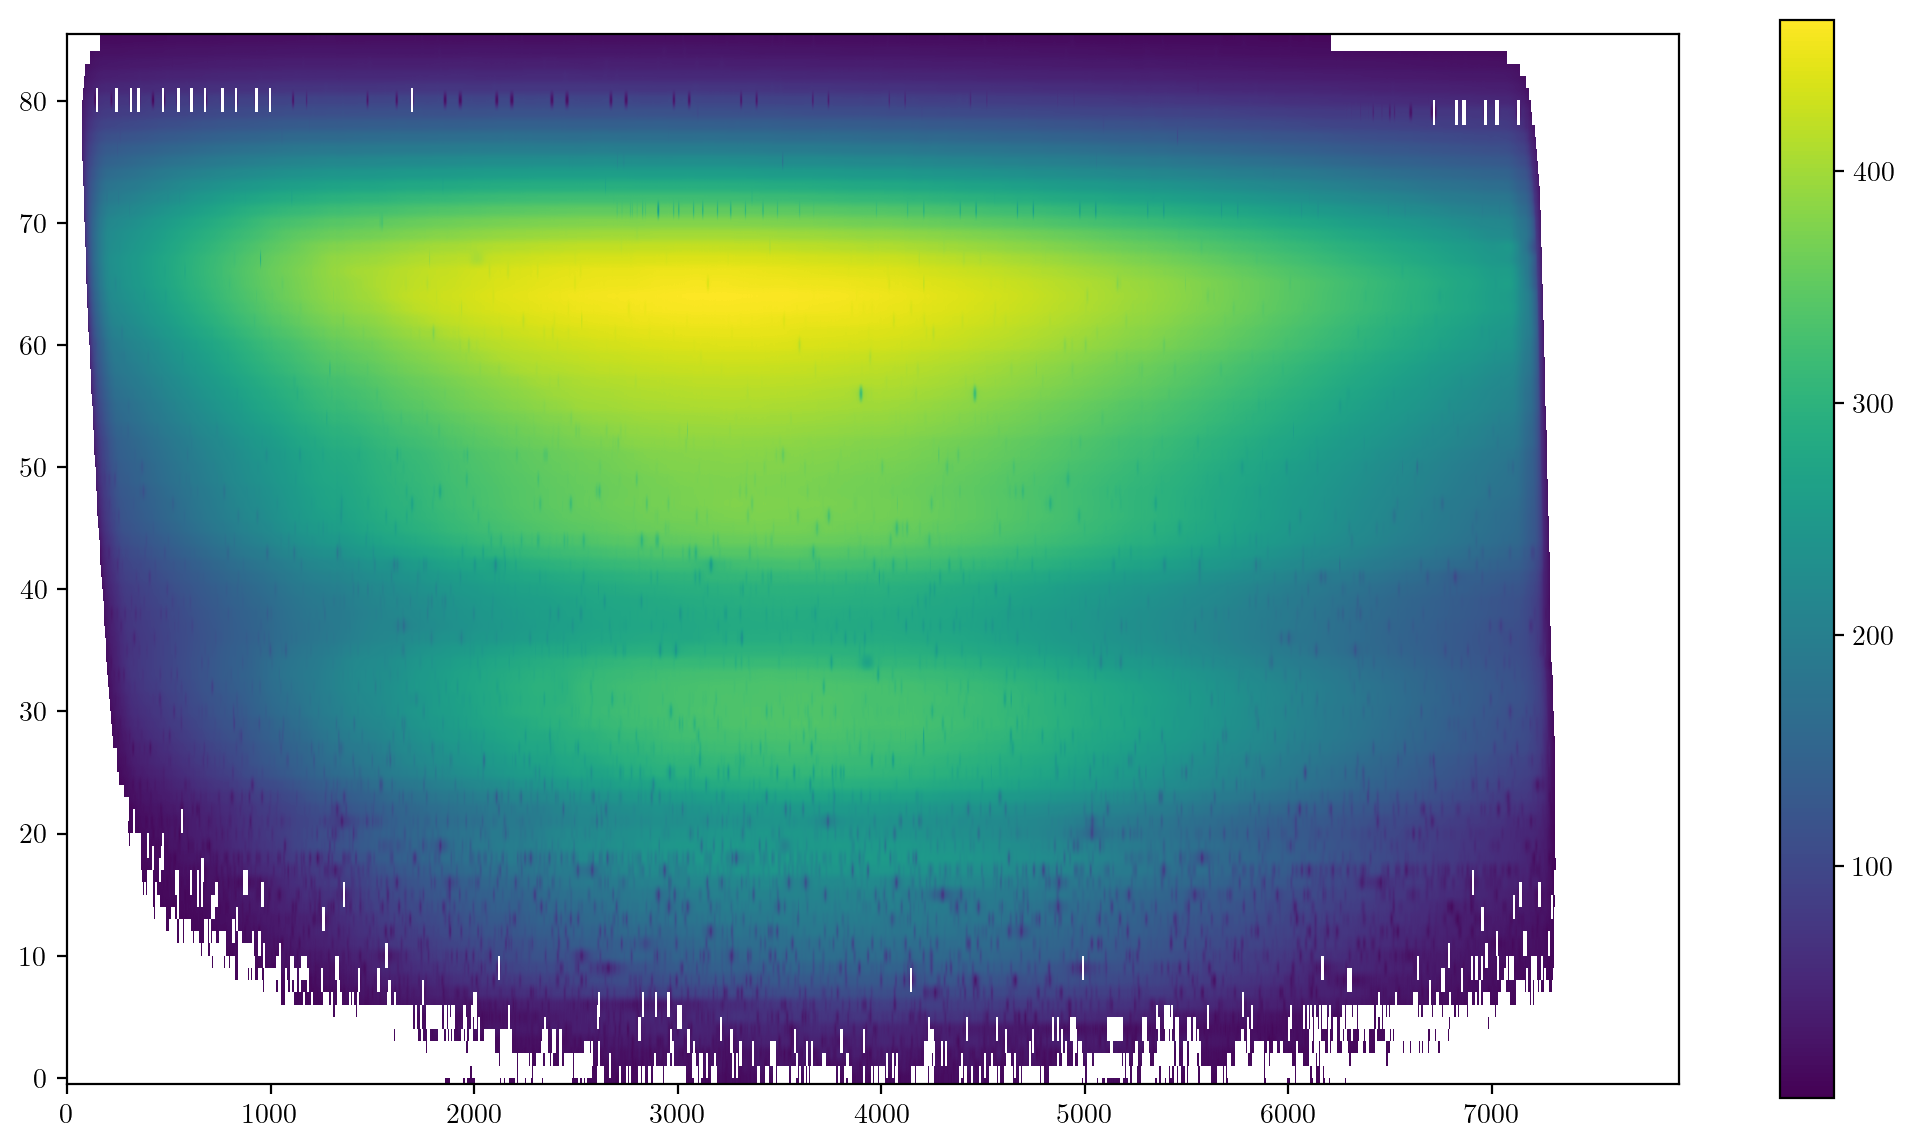

In [6]:
q = data['uncertainty'] / np.sqrt(data['spectrum'])
plt.imshow(1/q, aspect=60, origin='lower')
plt.colorbar()
plt.gcf().set_size_inches(13, 7)
plt.show()

In [7]:
def read_phoenix(teff, logg=logg, feh=feh):
    file = fmt.format(teff=teff, logg=logg, feh=feh)
    return fits.getdata(file)

def degrade(data, R0=137500):
    m = (λ >= np.nanmin(λ_expres)) & (λ <= np.nanmax(λ_expres))
    inter_sharp = UnivariateSpline(λ[m], data[m], s=0)

    # generate equisampled spectrum

    λ_equal = np.linspace(np.min(λ[m]), np.max(λ[m]), len(λ[m]))
    R = λ_equal / np.gradient(λ_equal)
    σ = np.median(R / R0) / np.sqrt(8 * np.log(2))
    y = inter_sharp(λ_equal)
    
    # degrade to desired resolution

    y_degraded = gaussian_filter1d(y, σ, mode='nearest')
    d_ = UnivariateSpline(λ_equal, y_degraded, s=0)
    return d_

def reformat(teff, **kwargs):
    data = read_phoenix(teff, **kwargs)
    d_ = degrade(data)
    
    y = d_(λ_expres)
    y[np.isnan(y) | mask_expres] = np.nan

    y_color_corr = np.nansum(y, axis=1)
    p = np.polyfit(λ_color_corr, np.log(y_color_corr), N_color_corr)

    y = y / np.exp(np.polyval(p, λ_expres)) * np.exp(np.polyval(p_color_corr, λ_expres))
    e_y = q * np.sqrt(y)
    e_y[np.isnan(e_y) | mask_expres] = np.nan
    return y, e_y

def compute_ccf(y, e_y):
    y[np.isnan(y)] = 0
    e_y[np.isnan(e_y)] = 0
    orders, ccfs, e_ccfs = order_wise_ccfs(masks, v_grid, λ_expres, y, e_y)
    ccf, _ = coadd_ccfs(ccfs, e_ccfs, orders, blue=BLUE_ORDER, red=RED_ORDER)
    return ccf

def process(teff, **kwargs):
    y, e_y = reformat(teff, **kwargs)
    return (lambda x: x / np.median(x))(compute_ccf(y, e_y))

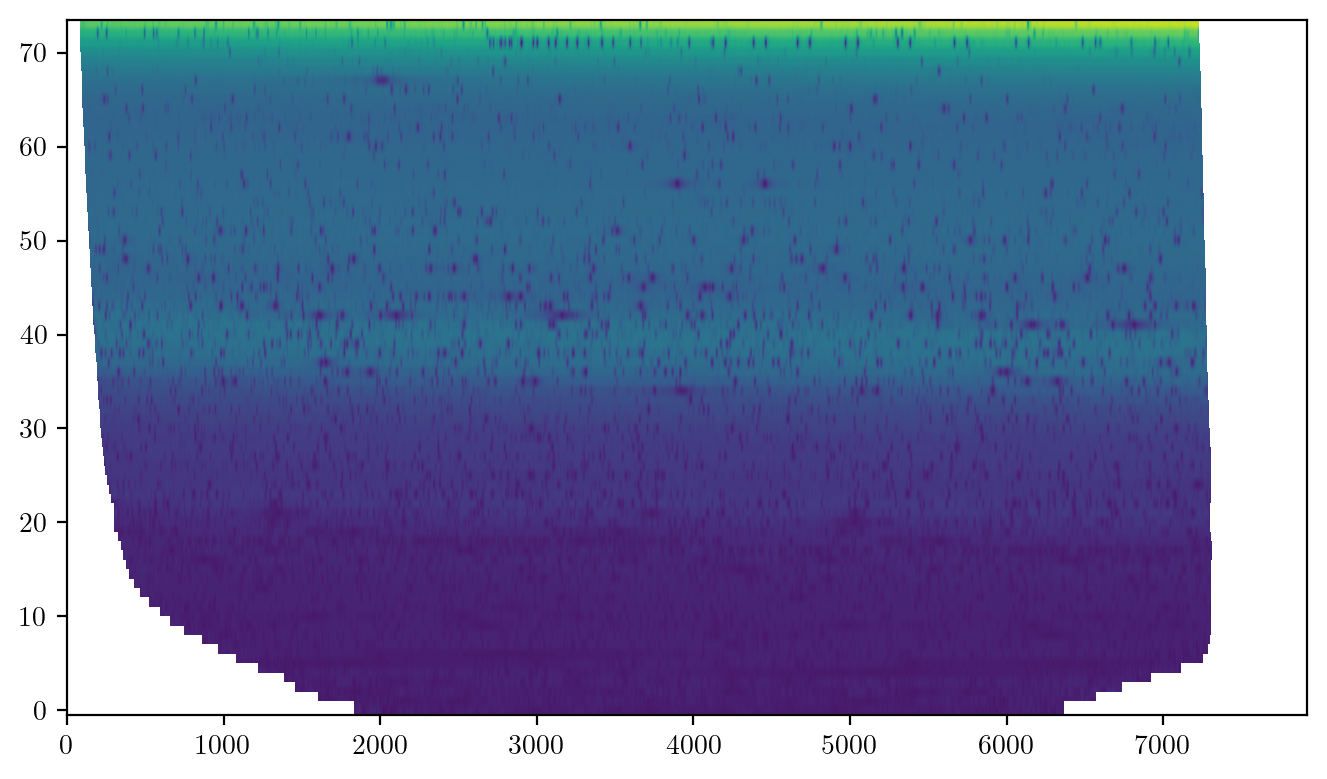

In [8]:
plt.imshow(data['spectrum'][:-12], origin='lower', aspect=60)

<ipython-input-9-dde2be8edbcf>:1: RankWarning: Polyfit may be poorly conditioned
  plt.imshow(reformat(5500)[0][:-12], origin='lower', aspect=60)


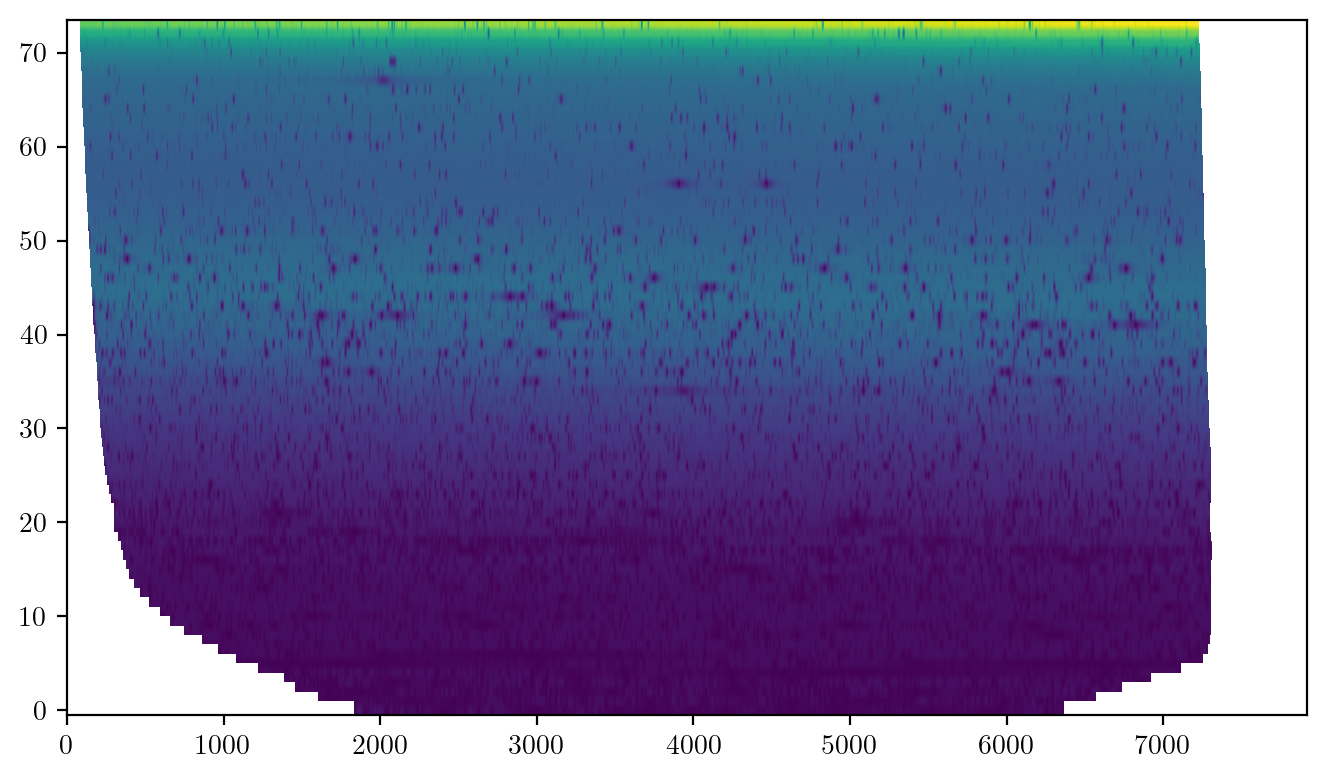

In [9]:
plt.imshow(reformat(5500)[0][:-12], origin='lower', aspect=60)

In [10]:
T_values = 2300 + np.arange(48)*100

In [ ]:
acc = {}
acc['v'] = v_grid

for _ in tqdm(T_values):
    acc[float(_)] = process(_)
    
np.save(f"PHOENIX_{logg:.2f}_{feh:.2f}_{mask}", acc)